In [48]:
# import all relevant libraries here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns

import wfdb
from wfdb import processing


# assign the correct path to downloaded data and filenames
# realpath is this script path, while data is subfolder in the same dir
# parent_dir =  os.path.dirname(os.path.realpath(__file__))

parent_dir = os.path.abspath('')
data_dir =  os.path.join(parent_dir,'data')


filenames = []

for i in range(10):
    filenames.append('infant'+str(i+1))

# print and list all relevant filenames, as a quick check
print(parent_dir)
print(data_dir)
print(filenames)

def describe_df(df):
    desc = df.describe()
    desc.loc['count'] = desc.loc['count'].astype(int).astype(str)
    desc.loc['nunique'] = df.nunique()
    desc.loc['count_na'] = df.isna().sum()
    desc.iloc[1:] = desc.iloc[1:].applymap('{:.6f}'.format)
    print(desc)


d:\Github\ecg_resp
d:\Github\ecg_resp\data
['infant1', 'infant2', 'infant3', 'infant4', 'infant5', 'infant6', 'infant7', 'infant8', 'infant9', 'infant10']


In [49]:
df_csv = pd.DataFrame()

# if windows
if os.name == 'nt':
    df_csv = pd.read_csv(data_dir+'\processed\subsampled{postfix}.csv'.format(postfix='_'+filenames[2]))
else:
    df_csv = pd.read_csv(data_dir+'/processed/subsampled{postfix}.csv'.format(postfix='_'+filenames[2]))

# filter data both rows & columns
df = df_csv[20000:1000000].copy()
df = df[['hrs', 'resp']]

# add time from index
df['time'] = df.index

# remove outliers
min_hrs = df['hrs'].mean()-3*df['hrs'].std()
max_hrs = df['hrs'].mean()+3*df['hrs'].std()

df = df[(df['hrs']>min_hrs)&(df['hrs']<max_hrs)]

# add unique id everytime hrs change
df['id'] = (df[['hrs']].diff() != 0).cumsum()

# print descriptions of the df
describe_df(df)


                 hrs         resp           time            id
count         961185       961185         961185        961185
mean      126.252488    21.079591  504740.969562  16825.630916
std        12.875188     4.994202  281715.626518   9594.761436
min        81.521736    -0.007678   20000.000000      1.000000
25%       119.047620    21.658926  260819.000000   8436.000000
50%       123.456790    22.079819  503096.000000  17180.000000
75%       129.310350    22.518861  746217.000000  25069.000000
max       172.413790    44.142887  999999.000000  32603.000000
nunique   190.000000  8324.000000  961185.000000  32603.000000
count_na    0.000000     0.000000       0.000000      0.000000


<AxesSubplot:ylabel='resp'>

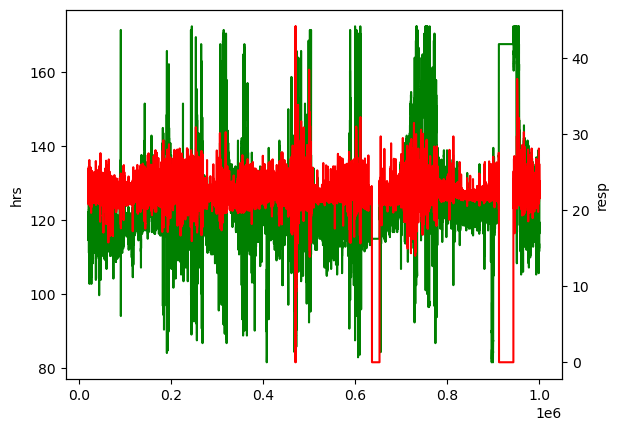

In [50]:
# plot 

sns.lineplot(data=df['hrs'], color="g")
# sns.lineplot(data=df['resp'], color="r")
ax2 = plt.twinx()
# sns.lineplot(data=df['sig'], color="b", ax=ax2)
sns.lineplot(data=df['resp'], color="r", ax=ax2)

In [51]:
s = pd.Series(range(1, df['id'].nunique()+1))
dfy = pd.DataFrame({'id': s})
dfy = pd.merge(dfy, df[['hrs', 'id']], on="id", how='outer')
dfy = dfy.drop_duplicates()

# shift 1 row
dfy.loc[:, 'hrs'] = dfy.hrs.shift(-1)
dfy = dfy.dropna()

dfy

id         hrs
0           1  126.050420
11          2  127.118645
34          3  129.310350
57          4  127.659580
81          5  128.205120
...       ...         ...
961062  32598  120.967740
961087  32599  126.050420
961111  32600  125.523010
961135  32601  127.118645
961158  32602  126.582275

[32602 rows x 2 columns]

In [52]:
%matplotlib inline

import matplotlib.pylab as plt

import tsfresh
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

filtered_features = pd.read_csv(data_dir+'\\processed\\tsfeatures.csv')
kind_to_fc_parameters = tsfresh.feature_extraction.settings.from_columns(filtered_features)



dfx = extract_features(df[['id', 'time', 'resp']], column_id='id', column_sort='time',
                     kind_to_fc_parameters=kind_to_fc_parameters)



Feature Extraction: 100%|██████████| 30/30 [08:21<00:00, 16.71s/it]


In [53]:
import xgboost as xg
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score
  
# Load the data
# dataset = dfr
# # drop = ['hrs', 'sig_min', 'sig_mean', 'sig_max' ]
# y_col = ['hrs']
# X, y =  dataset.drop(columns=y_col), dataset[y_col]

X, y = dfx[:-1], dfy['hrs']
  
# Splitting
train_X, test_X, train_y, test_y = train_test_split(X, y,
                      test_size = 0.3, random_state = 123)

# set objective
# obj = 'reg:linear' # deprecated, change to squarederror
obj = 'reg:squarederror'
# obj = 'reg:pseudohubererror'
  
# Instantiation
xgb_r = xg.XGBRegressor(objective = obj,
                  n_estimators = 1000, seed = 123)
  
# Fitting the model
xgb_r.fit(train_X, train_y)
  
# Predict the model
pred = xgb_r.predict(test_X)
  
# RMSE Computation
rmse = np.sqrt(MSE(test_y, pred))
print("RMSE : % f" %(rmse))

# r2square compution
r2 = r2_score(test_y, pred)
print("R2 : % f" %(r2))

c:\Users\hafiidz\anaconda3\envs\boost\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


RMSE :  4.660507
R2 :  0.812658


<AxesSubplot:xlabel='y_actual', ylabel='y_pred'>

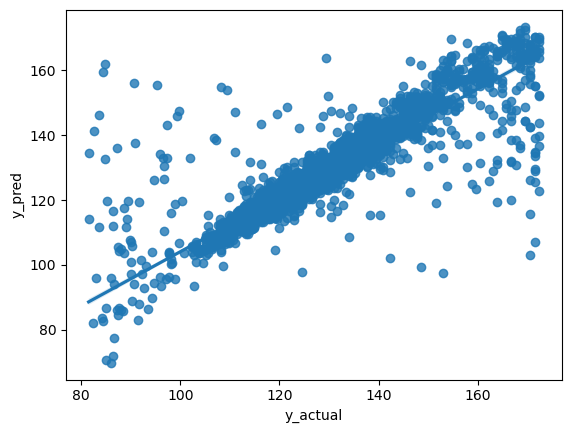

In [54]:
dft = pd.DataFrame({'y_actual':test_y, 'y_pred': pred})

sns.regplot(data=dft, x='y_actual', y='y_pred')


In [58]:
# df_csv = pd.read_csv(data_dir+'\processed\subsampled{postfix}.csv'.format(postfix='_'+filenames[2]))

# filter data both rows & columns
df2 = df_csv[1700000:2000000]
df2 = df2[['hrs', 'resp']]

# add time from index
df2['time'] = df2.index

# add unique id everytime hrs change
df2['id'] = (df2[['hrs']].diff() != 0).cumsum()

# print descriptions of the df
describe_df(df2)


dfx2 = extract_features(df2[['id', 'time', 'resp']], column_id='id', column_sort='time',
                     kind_to_fc_parameters=kind_to_fc_parameters)

s2 = pd.Series(range(1, dfx2.shape[0]+1))
dfy2 = pd.DataFrame({'id': s2})
dfy2 = pd.merge(dfy2, df2[['hrs', 'id']], on="id", how='outer')
dfy2 = dfy2.drop_duplicates()


# shift 1 row
dfy2.loc[:, 'hrs'] = dfy2.hrs.shift(-1)
dfy2 = dfy2.dropna()

dfy2

                 hrs         resp            time            id
count         300000       300000          300000        300000
mean      128.933774    22.252992  1849999.500000   5456.705380
std        12.940944     1.313107    86602.684716   3154.763237
min        75.376884    -0.007678  1700000.000000      1.000000
25%       120.481926    21.865534  1774999.750000   2697.000000
50%       125.523010    22.086799  1849999.500000   5458.000000
75%       133.928570    22.435101  1924999.250000   8200.250000
max       214.285720    44.054241  1999999.000000  10878.000000
nunique   171.000000  5436.000000   300000.000000  10878.000000
count_na    0.000000     0.000000        0.000000      0.000000


Feature Extraction: 100%|██████████| 30/30 [01:21<00:00,  2.73s/it]


id        hrs
0           1  147.78325
4           2  149.25374
25          3  147.78325
45          4  150.00000
65          5  148.51485
...       ...        ...
299851  10873  125.00000
299875  10874  123.96694
299899  10875  125.52301
299923  10876  124.48133
299947  10877  125.00000

[10877 rows x 2 columns]

<AxesSubplot:ylabel='resp'>

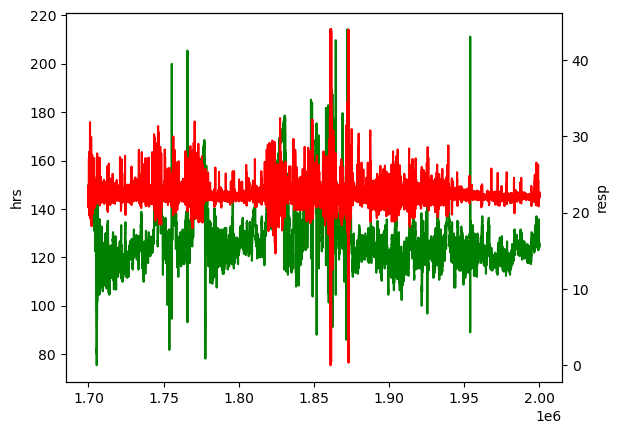

In [59]:
# plot 

sns.lineplot(data=df2['hrs'], color="g")
# sns.lineplot(data=df['resp'], color="r")
ax2 = plt.twinx()
# sns.lineplot(data=df['sig'], color="b", ax=ax2)
sns.lineplot(data=df2['resp'], color="r", ax=ax2)

RMSE :  4.660507
R2 :  0.810218


<AxesSubplot:xlabel='y_actual', ylabel='y_pred'>

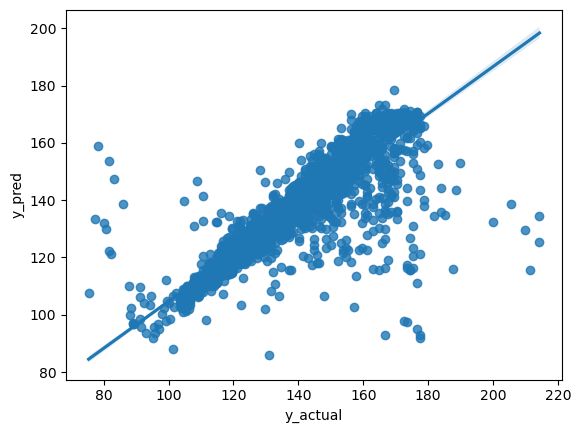

In [61]:
blind_X, blind_y = dfx2[:-1], dfy2['hrs']

# Predict the model
blind_pred = xgb_r.predict(blind_X)
  
# RMSE Computation
blind_rmse = np.sqrt(MSE(blind_y, blind_pred))
print("RMSE : % f" %(rmse))

# r2square compution
blind_r2 = r2_score(blind_y, blind_pred)
print("R2 : % f" %(blind_r2))


dft = pd.DataFrame({'y_actual':blind_y, 'y_pred': blind_pred})

sns.regplot(data=dft, x='y_actual', y='y_pred')

In [63]:
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score



# Initialize data
X, y = dfx[:-1], dfy['hrs']
  
# Splitting
train_X, test_X, train_y, test_y = train_test_split(X, y,
                      test_size = 0.3, random_state = 123)


# Initialize CatBoostRegressor
cat = CatBoostRegressor(iterations=20,
                          learning_rate=1,
                          depth=14)
 
# Fitting the model
cat.fit(train_X, train_y)
  
# Predict the model
pred = cat.predict(test_X)
  
# RMSE Computation
rmse = np.sqrt(MSE(test_y, pred))
print("RMSE : % f" %(rmse))

# r2square compution
r2 = r2_score(test_y, pred)
print("R2 : % f" %(r2))

c:\Users\hafiidz\anaconda3\envs\boost\lib\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


0:	learn: 4.6817941	total: 4.84s	remaining: 1m 31s
1:	learn: 4.0171938	total: 9.63s	remaining: 1m 26s
2:	learn: 3.6456282	total: 14.6s	remaining: 1m 22s
3:	learn: 3.3028827	total: 19.3s	remaining: 1m 17s
4:	learn: 3.0791997	total: 24.4s	remaining: 1m 13s
5:	learn: 2.9249126	total: 29.2s	remaining: 1m 8s
6:	learn: 2.8364024	total: 35s	remaining: 1m 5s
7:	learn: 2.7198608	total: 41.2s	remaining: 1m 1s
8:	learn: 2.6101626	total: 47.6s	remaining: 58.1s
9:	learn: 2.4716854	total: 53.9s	remaining: 53.9s
10:	learn: 2.3999891	total: 1m	remaining: 49.1s
11:	learn: 2.3719428	total: 1m 6s	remaining: 44.3s
12:	learn: 2.2875123	total: 1m 12s	remaining: 39.1s
13:	learn: 2.2227336	total: 1m 18s	remaining: 33.7s
14:	learn: 2.2084844	total: 1m 24s	remaining: 28.2s
15:	learn: 2.1557923	total: 1m 30s	remaining: 22.7s
16:	learn: 2.0902971	total: 1m 36s	remaining: 17.1s
17:	learn: 2.0398289	total: 1m 43s	remaining: 11.5s
18:	learn: 1.9677601	total: 1m 49s	remaining: 5.76s
19:	learn: 1.8813731	total: 1m 55s

<AxesSubplot:xlabel='y_actual', ylabel='y_pred'>

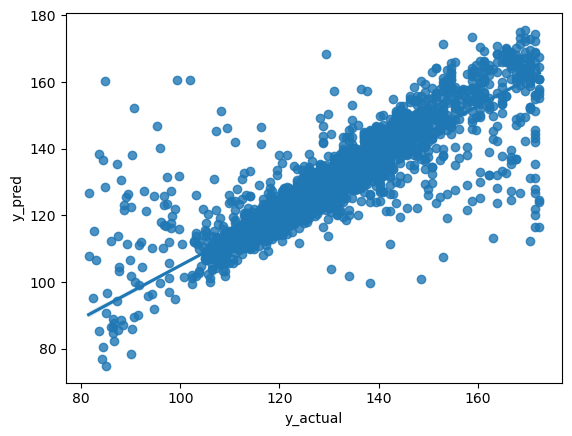

In [64]:
dft = pd.DataFrame({'y_actual':test_y, 'y_pred': pred})

sns.regplot(data=dft, x='y_actual', y='y_pred')

c:\Users\hafiidz\anaconda3\envs\boost\lib\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


RMSE :  4.999996
R2 :  0.757203


<AxesSubplot:xlabel='y_actual', ylabel='y_pred'>

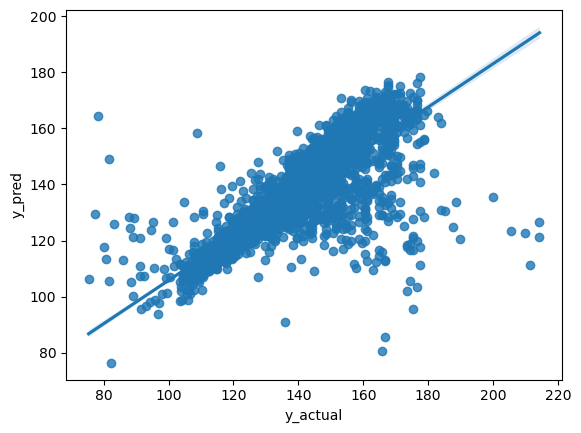

In [65]:
blind_X, blind_y = dfx2[:-1], dfy2['hrs']

# Predict the model
blind_pred = cat.predict(blind_X)
  
# RMSE Computation
blind_rmse = np.sqrt(MSE(blind_y, blind_pred))
print("RMSE : % f" %(rmse))

# r2square compution
blind_r2 = r2_score(blind_y, blind_pred)
print("R2 : % f" %(blind_r2))


dft = pd.DataFrame({'y_actual':blind_y, 'y_pred': blind_pred})

sns.regplot(data=dft, x='y_actual', y='y_pred')

In [67]:
df3_csv = pd.DataFrame()

# if windows
if os.name == 'nt':
    df3_csv = pd.read_csv(data_dir+'\processed\subsampled{postfix}.csv'.format(postfix='_'+filenames[9]))
else:
    df3_csv = pd.read_csv(data_dir+'/processed/subsampled{postfix}.csv'.format(postfix='_'+filenames[9]))

# filter data both rows & columns
df3 = df3_csv[20000:1000000].copy()
df3 = df3[['hrs', 'resp']]

# add time from index
df3['time'] = df3.index

# remove outliers
min_hrs = df3['hrs'].mean()-3*df3['hrs'].std()
max_hrs = df3['hrs'].mean()+3*df3['hrs'].std()

df3 = df3[(df3['hrs']>min_hrs)&(df3['hrs']<max_hrs)]

# add unique id everytime hrs change
df3['id'] = (df3[['hrs']].diff() != 0).cumsum()

# print descriptions of the df
describe_df(df3)


dfx3 = extract_features(df3[['id', 'time', 'resp']], column_id='id', column_sort='time',
                     kind_to_fc_parameters=kind_to_fc_parameters)

s3 = pd.Series(range(1, dfx3.shape[0]+1))
dfy3 = pd.DataFrame({'id': s3})
dfy3 = pd.merge(dfy3, df3[['hrs', 'id']], on="id", how='outer')
dfy3 = dfy3.drop_duplicates()


# shift 1 row
dfy3.loc[:, 'hrs'] = dfy3.hrs.shift(-1)
dfy3 = dfy3.dropna()

dfy3

                 hrs          resp           time            id
count         969634        969634         969634        969634
mean      151.151025     33.092940  509354.282530  19654.889998
std        14.119585      3.729715  282550.026980  11187.623827
min       104.529620     -0.019105   20000.000000      1.000000
25%       140.845080     32.065852  264732.250000  10002.000000
50%       150.753770     32.962771  509054.500000  19791.000000
75%       161.290330     34.125146  753940.750000  29157.000000
max       193.548390     65.876272  999999.000000  39097.000000
nunique   133.000000  10781.000000  969634.000000  39097.000000
count_na    0.000000      0.000000       0.000000      0.000000


Feature Extraction: 100%|██████████| 30/30 [03:54<00:00,  7.81s/it]


id        hrs
0           1  138.88889
22          2  142.18010
43          3  145.63107
63          4  142.85715
84          5  145.63107
...       ...        ...
969502  39092  140.84508
969523  39093  157.06807
969564  39094  124.48133
969588  39095  133.92857
969610  39096  139.53488

[39096 rows x 2 columns]

RMSE :  4.999996
R2 :  0.218475


<AxesSubplot:xlabel='y_actual', ylabel='y_pred'>

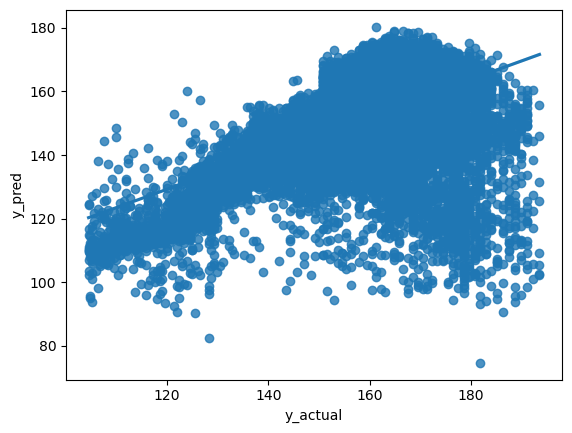

In [69]:
blind_X, blind_y = dfx3[:-1], dfy3['hrs']

# Predict the model
blind_pred = xgb_r.predict(blind_X)
  
# RMSE Computation
blind_rmse = np.sqrt(MSE(blind_y, blind_pred))
print("RMSE : % f" %(rmse))

# r2square compution
blind_r2 = r2_score(blind_y, blind_pred)
print("R2 : % f" %(blind_r2))


dft = pd.DataFrame({'y_actual':blind_y, 'y_pred': blind_pred})

sns.regplot(data=dft, x='y_actual', y='y_pred')